# Анализ вакансии для аналитиков данных в LinkedIn

Ссылка на дашборд: https://datalens.yandex/ui538detirbck?state=*707e557a407

### Вводные данные
В нашем распоряжении имеется выгрузка данных c вакансиями на позицию аналитика данных с сервиса Linkedin. Данные актуальны на 23.05.2023. <br>
Ссылка на файл с данными: https://drive.google.com/file/d/1Hb2ULSNXisaR0XU3miJ073z3mscEoG2d/view?usp=sharing

### Цель исследования:
Изучить данные, привести их в пригодный для анализа формат. Визуализировать информацию о рынке вакансий для аналитиков в Европе (LinkedIn) в разрезе таких характеристик как страна, формат работы, требуемые hurd скилы, компании и тд.

### Этапы проекта:
Работу над проектом будем проводить в несколько этапов:
1. Загрузка csv и парсинг данных в пригодный для анализа формат
2. Предобработка данных
3. Исследовательский анализ и подготовка к визуализации
3. Визуализация данных - построение интерактивного дашборда в BI системе



## Загрузка и парсинг данных в пригодный для анализа формат

### Загрузка csv - файла

Добавим необходимые бибилиотеки для работы и загрузим csv-файл по ссылке выше.

In [ ]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from IPython.display import display, HTML
import math as mth
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime as dt
from datetime import timedelta
from matplotlib import pyplot as plt
import re
#from google.colab import drive
#drive.mount('drive')


In [ ]:

#загрузка файла
link = 'https://drive.google.com/file/d/1Hb2ULSNXisaR0XU3miJ073z3mscEoG2d/view?usp=sharing'
# обращение к гугл-файлу по id, для корректного открытия
link='https://drive.google.com/uc?id=' + link.split('/')[-2]

try:
  jobs = pd.read_csv(link, index_col=0)
except:
  jobs = pd.read_csv("https://disk.yandex.ru/d/Rlo2KdJRve6fkw", index_col=0)

jobs.head()

,html
0,"\n <div>\n <div class=""\n jobs-deta..."
1,"\n <div>\n <div class=""\n jobs-deta..."
2,"\n <div>\n <div class=""\n jobs-deta..."
3,"\n <div>\n <div class=""\n jobs-deta..."
4,"\n <div>\n <div class=""\n jobs-deta..."


In [ ]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998 entries, 0 to 997
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   html    998 non-null    object
dtypes: object(1)
memory usage: 15.6+ KB


Датасет содержит только html, из него будем вытягивать всю информацию.

### Обзор данных

In [ ]:
#посмотрим содержимое колонки
BeautifulSoup(jobs.loc[0].item())

<html><body><div>
<div class="jobs-details__main-content jobs-details__main-content--single-pane full-width">
<!-- -->
<div>
<div class="jobs-unified-top-card t-14">
<!-- --> <div class="relative jobs-unified-top-card__container--two-pane">
<div class="jobs-unified-top-card__content--two-pane">
<!-- -->
<a class="ember-view" href="/jobs/view/3609065367/?alternateChannel=search&amp;refId=AxoCJAz0Vnn3xzCIlNO7ng%3D%3D&amp;trackingId=mdZWGb64G6DZP8qCAPQ%2BmQ%3D%3D&amp;trk=d_flagship3_search_srp_jobs" id="ember425">
<h2 class="t-24 t-bold jobs-unified-top-card__job-title">Data Analyst</h2>
</a>
<div class="jobs-unified-top-card__primary-description">
<span class="jobs-unified-top-card__subtitle-primary-grouping t-black">
<span class="jobs-unified-top-card__company-name">
<a class="ember-view t-black t-normal" href="/company/pharmiweb-jobs/life/" id="ember426">
                    PharmiWeb.Jobs: Global Life Science Jobs
                  </a>
</span>
<span class="jobs-unified-top-card__bull

Посмотрим в среде тетрадки, как выглядят вакансии на сайте linkedin

In [ ]:
display(HTML(jobs['html'][350]))

### Добавление характеристик вакансий в датафрейм

Если посмотреть страницы нескольких вакансйи, то несложно заметить, что почти все они обладают некоторым набором характеристик. Попробуем их вытащить и создать для каждого отдельный столбец. Нам потребуется найти:
*   наименование вакансии
*   город
*   страна
*   тип занятости (online, hybride, on-site)
*   компания
*   размер компании (количество работников)
*   сфера деятельности компании
*   требуемые хард скилы
*   дата публикации вакансии
*   количество кандидатов на вакансию



Напишем функцию, которая будет из описания html вытаскивать сырые данные по большинству из требуемых характеристик, все шероховатости мы устраним на этапе предобработки.

Создадим тестовый датафрей, на котором будем обкатывать функцию.

In [ ]:
#тестовый датафрейм
db = jobs.head(6).append(jobs.tail(6)).copy()
db = db.reset_index(drop = True)
db

,html
0,"\n <div>\n <div class=""\n jobs-deta..."
1,"\n <div>\n <div class=""\n jobs-deta..."
2,"\n <div>\n <div class=""\n jobs-deta..."
3,"\n <div>\n <div class=""\n jobs-deta..."
4,"\n <div>\n <div class=""\n jobs-deta..."
5,"\n <div>\n <div class=""\n jobs-deta..."
6,"\n <div>\n <div class=""\n jobs-deta..."
7,"\n <div>\n <div class=""\n jobs-deta..."
8,"\n <div>\n <div class=""\n jobs-deta..."
9,"\n <div>\n <div class=""\n jobs-deta..."


Предварительно просмотрев несколько вакансий, мы обнаружили, что некоторые  характеристики, такие как тип удаленной занятости или hurd-скилы указаны неявно, их нужно искать по тексту описания вакансии. Поэтому создадим вспомогательную функцию, которая будет искать в описании вакансии необходимые нам ключевые слова.

In [ ]:
def find_keywords(cell, check_list):
  """
  Функция берет текстовое описание вакансии, ищет в нем ключевые слова из
  переданного списка. На выходе возвращает строку с перечнем всех найденных
  ключевых слов через запятую.

  Parameters:
  сell - поле с текстом, по которому будет происходить поиск ключевых слов
  check_list - список ключевых слов для поиска
  """

  key_list=[]
  for i in check_list:
      pattern = (
          r'(\b|\W)'
          + re.escape(i)
          + r'(\b|\W)'
          +'|'
          + r'(\b|\W)'
          +re.escape(i.replace(' ', ''))
          + r'(\b|\W)'
      )
      if re.search(pattern, cell.lower()):
            key_list.append(i)
  if len(key_list)!=0:
    return (','.join(key_list))
  else:
    return 'unknown'

Создадим список ключевых слов для типа удаленной работы.

In [ ]:
workplace = ['remote','hybrid','on site', 'onsite','on-site', 'from home', 'from office', 'home office']

И отдельно создадим список с перечнем основных hurd-скилов, которые встречаются в требованиях к аналитикам.

In [ ]:
skills = [ 'a/b testing', 'ab testing', 'actian', 'adobe analytics', 'adobe audience manager',
          'adobe experience platform', 'adobe launch', 'adobe target', 'ai', 'airflow', 'agile', 'alooma',
          'alteryx', 'amazon machine learning', 'amazon web services', 'aml', 'amplitude', 'ansible',
          'apache camel', 'apache nifi', 'apache spark', 'api', 'asana', 'auth0', 'aws', 'aws glue',
          'azure', 'azure data factory', 'basecamp', 'bash', 'beats', 'big query', 'bigquery', 'birst',
          'bitbucket', 'blendo', 'bootstrap', 'business objects bi', 'c#', 'c++', 'caffe', 'cassandra',
          'cdata sync', 'chronograf', 'ci/cd', 'cicd', 'clickhouse', 'cloudera', 'cluvio', 'cntk', 'cognos',
          'composer', 'computer vision', 'conda', 'confluence', 'couchbase', 'css', 'd3.js', 'dash', 'dashboard',
          'data pipelines', 'data engineering',
          'data factory', 'data fusion', 'data mining', 'data studio', 'data warehouse', 'databricks', 'dataddo',
          'dataflow', 'datahub', 'dataiku', 'datastage', 'dbconvert', 'dbeaver', 'dbt', 'deep learning', 'dl/ml',
          'docker', 'domo', 'dune', 'dv360', 'dynamodb', 'elasticsearch', 'elt', 'erwin', 'etl', 'etleap', 'excel',
          'facebook business manager', 'fivetran', 'fuzzy', 'ga360', 'gcp', 'gensim', 'ggplot', 'git', 'github',
          'gitlab', 'google ads', 'google analytics', 'google cloud platform', 'google data flow', 'google optimize',
          'google sheets', 'google tag manager', 'google workspace', 'grafana', 'hadoop', 'hana', 'hanagrafana', 'hbase',
          'hdfs', 'hevo data', 'hightouch', 'hive', 'hivedatabricks', 'html', 'hubspot', 'ibm coremetrics', 'inetsoft',
          'influxdb', 'informatica', 'integrate.io', 'iri voracity', 'izenda', 'java', 'java script', 'javascript', 'jenkins',
          'jira', 'jmp', 'julia', 'jupyter', 'k2view', 'kafka', 'kantar', 'kapacitor', 'keras', 'kibana', 'kubernetes',
          'lambda', 'linux', 'logstash', 'looker', 'lstm', 'luidgi', 'matillion', 'matlab', 'matplotlib', 'mendix', 'metabase',
          'microsoft sql', 'microsoft sql server', 'microstrategy', 'miro', 'mixpanel', 'ml', 'ml flow', 'mlflow', 'mongodb',
          'mxnet', 'mysql', 'ms office', 'natural nanguage processing', 'neo4j', 'nlp', 'nltk', 'nosql', 'numpy', 'oauth', 'octave', 'omniture',
          'omnituregitlab', 'openshift', 'openstack', 'optimizely', 'oracle', 'oracle business intelligence', 'oracle data integrator',
          'pandas', 'panorama', 'pentaho', 'plotly', 'postgre', 'postgresql', 'posthog', 'power amc', 'power bi', 'power point',
          'powerbi', 'powerpivot', 'powerpoint', 'powerquery', 'pyspark', 'python', 'pytorch', 'pytorchhevo data', 'qlik',
          'qlik sense', 'qlikview', 'querysurge', 'r', 'raphtory', 'rapidminer', 'redash', 'redis', 'redshift', 'retool',
          'rivery', 'rust', 's3', 'sa360', 'salesforce', 'sap', 'sap business objects', 'sas', 'sas visual analytics', 'scala',
          'scikit-learn', 'scipy', 'seaborn', 'segment', 'selenium', 'sem rush', 'semrush', 'shell', 'shiny', 'singer', 'sisense',
          'skyvia', 'snowflake', 'spacy', 'spark', 'sparkml', 'splunk', 'spotfire', 'spreadsheet', 'spss', 'sql', 'ssis', 'sssr',
          'stambia', 'statistics', 'statsbot', 'stitch', 'streamlit', 'streamsets', 'svn', 't-sql', 'tableau', 'talend', 'targit',
          'tealium', 'telegraf', 'tensorflow', 'terraapi', 'terraform', 'theano', 'thoughtspot', 'timeseries', 'trello', 'unix', 'vba',
          'vtom', 'webfocus', 'wfh', 'xplenty', 'xtract.io', 'yellowfin']

In [ ]:
def create_characteristics(db, job_html='html'):
  """
  На входе функция принимает описание вакансии в формате строки (html)

  Parameters:
  """
  #id вакансии - id_job
  db['id_job'] =  db[job_html].apply(lambda x: BeautifulSoup(x).find("a",{"class":"ember-view"}).get("href").split('/')[3])

  # Название вакансии - name
  db['name'] = db[job_html].apply(lambda x: BeautifulSoup(x).find('h2').text.strip() if BeautifulSoup(x).find('h2') else 'unknown') #если тега не будет, то запишется unknown

  #название компании - company_name
  db['company_name'] = db[job_html].apply(lambda x: BeautifulSoup(x).find('span', class_ = 'jobs-unified-top-card__company-name').text.strip()
  if BeautifulSoup(x).find('span', class_ = 'jobs-unified-top-card__company-name') else 'unknown')

  #тип занятости - workplace_type
  db['workplace_type'] = db[job_html].apply(lambda x: BeautifulSoup(x)
  .find('span', class_='jobs-unified-top-card__workplace-type')
  .text.lower().strip() if BeautifulSoup(x)
  .find('span', class_='jobs-unified-top-card__workplace-type') else find_keywords(x,workplace))


  # количество сотрудников -  company_staff
  db['company_staff']  = db[job_html].apply(lambda x: BeautifulSoup(x)
  .find_all('li', class_='jobs-unified-top-card__job-insight')[1].text.strip()
  .split(' · ')[0] if BeautifulSoup(x).find_all('li', class_='jobs-unified-top-card__job-insight') else 'unknown')
  #заменим на unknown все строки, где нет employees
  db['company_staff'] = db['company_staff'].apply(lambda x:
                                                  x if 'employees' in x else 'unknown')

  #сфера деятельности компании - company_scope
  db['company_scope']  = db[job_html].apply(lambda x:
                                            BeautifulSoup(x).find_all('li', class_='jobs-unified-top-card__job-insight')[1]
                                            .text.strip().split(' · ')[-1]
                                            if BeautifulSoup(x).find_all('li', class_='jobs-unified-top-card__job-insight') else 'unknown')
  #заменим на unknown все строки, где указана численность или число откликнувшихся
  db['company_scope'] = db['company_scope'].apply(lambda x: 'unknown' if ('employees' in x or  'applicants' in x) else x)

  #дата публикации вакансии - date_publication
  db['date_publication']  = db[job_html].apply(lambda x:
                                           BeautifulSoup(x).find('span', class_='jobs-unified-top-card__posted-date').text.strip())

  #кол-во кандидатов на вакансию - applicants
  db['applicants']  = db[job_html].apply(lambda x: BeautifulSoup(x).find_all('span', class_='jobs-unified-top-card__bullet')[1].text.strip())
  db['applicants'] = db['applicants'].apply(lambda x: x if 'applicants' in x  else "unknown")

  #локация - location
  db['location'] = db[job_html].apply(lambda x: BeautifulSoup(x).find(class_ ="jobs-unified-top-card__bullet").text.strip())

  #описание вакансии - description
  db['description'] = db[job_html].apply(lambda x: BeautifulSoup(x).find(id = 'job-details').text)
  db['description'] = db['description'].apply(lambda x: x.replace('De',' De')) #доп.обработка добавлена после проверки

  #hurd скилы - skills
  db['skills'] = db['description'].apply(lambda x: find_keywords(x,skills))

  return db;

In [ ]:
db = create_characteristics(db)

Функция работает, запустим ее на полный датасет.
Обработка занимает примерно 5 минут.

In [ ]:
jobs = create_characteristics(jobs)

In [ ]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998 entries, 0 to 997
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   html              998 non-null    object
 1   id_job            998 non-null    object
 2   name              998 non-null    object
 3   company_name      998 non-null    object
 4   workplace_type    998 non-null    object
 5   company_staff     998 non-null    object
 6   company_scope     998 non-null    object
 7   date_publication  998 non-null    object
 8   applicants        998 non-null    object
 9   location          998 non-null    object
 10  description       998 non-null    object
 11  skills            998 non-null    object
dtypes: object(12)
memory usage: 133.6+ KB


Столбцы с ключевыми характеристиками найдены, теперь займемся предобработкой распарсенных данных.

## Предобработка данных

###Общие проверки

Сначала удалим явные дубликаты, если они есть

In [ ]:
 #проверка на явные дубликаты
jobs.duplicated().sum()


98

In [ ]:
jobs = jobs.drop_duplicates().reset_index(drop=True)
print(jobs.duplicated().sum())
print(jobs.shape[0])

0
900


Теперь проверим неявные дубликаты - проерим дубли по id вакансии, а так же по названию, компании, локации и набору скилов.

In [ ]:
jobs[['id_job']].duplicated().sum()

13

In [ ]:
jobs = jobs.drop_duplicates(subset=['id_job'], keep='first')
print(jobs.shape[0])

887


In [ ]:
jobs[['name','company_name','location','skills']].duplicated().sum()

4

In [ ]:
jobs = jobs.drop_duplicates(subset=['name','company_name','location','skills'], keep='first')
print(jobs.shape[0])

883


Выполним проверку на пустые строки и значения unknown в столбцах

In [ ]:
#проверка на пустые строки в столбцах
print('% пустых строк в каждом столбце: \n')
for i in jobs.columns:
    print(i, '-', jobs[jobs[i]==""][i].count())

% пустых строк в каждом столбце: 

html - 0
id_job - 0
name - 0
company_name - 2
workplace_type - 0
company_staff - 0
company_scope - 0
date_publication - 0
applicants - 0
location - 0
description - 0
skills - 0


In [ ]:
jobs = jobs.query('company_name!=""')
print(jobs.shape[0])

881


In [ ]:
#проверка на пропуски (unknown)
print('% неизвестных значений в каждом столбце: \n')
for i in jobs.columns:
    print(i, '-', '{:.2%}'.format(jobs[jobs[i]=="unknown"][i].count()/jobs.shape[0]))

% неизвестных значений в каждом столбце: 

html - 0.00%
id_job - 0.00%
name - 0.00%
company_name - 0.00%
workplace_type - 4.31%
company_staff - 3.06%
company_scope - 9.08%
date_publication - 0.00%
applicants - 8.17%
location - 0.00%
description - 0.00%
skills - 8.97%


От unknown мы избавляться не будем, в нашем датасете получились адекватные показатели неявных пропусков.

### Название вакансии

Посмотрим, какие вакансии присутствуют в нашем датасете.

In [ ]:
jobs['name'].value_counts(dropna=False).head(50)

Data Analyst                                                      93
Data Analyst - Milano                                             27
Online Data Analyst                                               20
Stage | Data Analyst                                              17
Data Scientist                                                    16
Data Analyst (m/w/d)                                              16
Business Analyst                                                  15
Data Engineer                                                     15
Product Data Analyst                                              10
Junior Business Analyst                                            6
Junior Data Analyst                                                6
Data Analyst H/F                                                   5
Business Intelligence Developer                                    5
Business Intelligence Analyst                                      5
BI Specialist                     

Очевидно, парсинг собрал не только аналитиков данных, но так же программистов, инженеров и еще других разноплановых аналитиков. Попробуем избавиться от лишнего, чтобы в дальнейшем было проще работать с данными.

Сформируем список ключевых слов, встречающихся в названии вакансиях аналитик данных и дата саентиста, прогоним про этому списку все названия. Оставим только те, где встречается что-то из ключевого списка.

In [ ]:
#список популярных слов в названии вакансии аналитика
str_filtr = 'data-analist|analyst|analist|scientist|science|analista|analytics|analityk|analytik|data-analist|bi expert|bi specialist|business intelligence expert|business intelligence specialist|business intelligence consultant|data visualization expert'

In [ ]:
filtr = jobs['name'].str.contains(str_filtr, flags=re.IGNORECASE, regex=True)#ходит по сериям и ищет вхождения без учета регистра
filtr.mean()

0.8093076049943246

Проверим, что отбросил фильтр

In [ ]:
jobs[~filtr]['name'].value_counts(dropna=False).head(50)

Data Engineer                                                           15
Business Intelligence Developer                                          5
Software Engineer                                                        4
Business Intelligence Engineer                                           3
BI Developer                                                             3
Process Engineer                                                         3
Data Specialist                                                          2
Reporting Specialist                                                     2
Data Engineer (SQL, BI)                                                  1
Senior BI Developer (SQL Server) – (Remote)                              1
Global HRIS Specialist                                                   1
Mid Data Engineer                                                        1
📢 [Full Remote] BI Engineer - Startup Data Marketing - H/F               1
Associate - Data Research

Фильтр отсек инжинеров и дазработчиков, доп. специалистов и менеджеров - в совокупности это почти 20% лишних данных. Пересохраним датасет с учетом фильтра.

In [ ]:
jobs = jobs[filtr].reset_index(drop=True)
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   html              713 non-null    object
 1   id_job            713 non-null    object
 2   name              713 non-null    object
 3   company_name      713 non-null    object
 4   workplace_type    713 non-null    object
 5   company_staff     713 non-null    object
 6   company_scope     713 non-null    object
 7   date_publication  713 non-null    object
 8   applicants        713 non-null    object
 9   location          713 non-null    object
 10  description       713 non-null    object
 11  skills            713 non-null    object
dtypes: object(12)
memory usage: 67.0+ KB


Уберем из списка еще несколько неподходящих направлений.

In [ ]:
negativ_filtr = 'financ|commercial|policy|engineer|developer|fp|operations|project|programmatore|programador'
filtr = jobs['name'].str.contains(negativ_filtr, flags=re.IGNORECASE, regex=True) #ходит по сериям и ищет вхождения без учета регистра
filtr.sum()

38

Таких вакансий нашлось мало, их можно удалить.

In [ ]:
jobs = jobs[~filtr].reset_index(drop=True)
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675 entries, 0 to 674
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   html              675 non-null    object
 1   id_job            675 non-null    object
 2   name              675 non-null    object
 3   company_name      675 non-null    object
 4   workplace_type    675 non-null    object
 5   company_staff     675 non-null    object
 6   company_scope     675 non-null    object
 7   date_publication  675 non-null    object
 8   applicants        675 non-null    object
 9   location          675 non-null    object
 10  description       675 non-null    object
 11  skills            675 non-null    object
dtypes: object(12)
memory usage: 63.4+ KB


Наш набор вакансий определен, идем дальше.

### Название компании

In [ ]:
jobs['company_name'].nunique()

503

Можно было бы поискать неявные дубликаты, но компаний слишком много, оставим все как есть.

### Тип занятости



In [ ]:
jobs.workplace_type.value_counts(dropna=False)

hybrid                       349
on-site                      215
remote                        74
unknown                       26
hybrid,from home               3
remote,hybrid                  3
from home                      1
remote,from home               1
remote,hybrid,home office      1
from home,home office          1
on site                        1
Name: workplace_type, dtype: int64

Укрупним однотипные значения

In [ ]:
rep_dic = {'hybrid,from home':'hybrid',
           'remote,hybrid':'hybrid',
           'remote,hybrid,home office':'hybrid',
           'from home':'remote',
           'remote,from home':'remote',
           'from home,home office':'remote',
           'on site':'on-site'}

In [ ]:
jobs['workplace_type'] = jobs['workplace_type'].replace(rep_dic)
jobs.workplace_type.value_counts(dropna=False)

hybrid     356
on-site    216
remote      77
unknown     26
Name: workplace_type, dtype: int64

После повторной проверки - все ок.

### Количество сотрудников



Проверим, что получилось в столбце

In [ ]:
jobs.company_staff.value_counts()

10,001+ employees         162
51-200 employees          139
1,001-5,000 employees     132
201-500 employees          56
501-1,000 employees        52
5,001-10,000 employees     50
11-50 employees            40
unknown                    26
1-10 employees             18
Name: company_staff, dtype: int64

Уберем employees из значений столбца, а unknown заменим на 0.

In [ ]:
jobs['company_staff'] = jobs['company_staff'].apply(lambda x: x.replace(' employees',''))
jobs.company_staff.value_counts()

10,001+          611
1,001-5,000      607
51-200           524
201-500          351
501-1,000        269
5,001-10,000     268
11-50            180
1-10              80
unknown           72
Name: company_staff, dtype: int64

### Cфера деятельности компании

Посмотрим, что получилось.

In [ ]:
jobs['company_scope'].value_counts().head(50)

IT Services and IT Consulting                            110
Retail                                                    59
Staffing and Recruiting                                   56
unknown                                                   43
Financial Services                                        42
Technology, Information and Internet                      28
Banking                                                   23
Business Consulting and Services                          22
Information Technology & Services                         19
Advertising Services                                      16
Software Development                                      16
Human Resources Services                                  12
Entertainment Providers                                   11
Motor Vehicle Manufacturing                               10
Transportation, Logistics, Supply Chain and Storage        9
Retail Apparel and Fashion                                 8
Oil and Gas             

In [ ]:
jobs[jobs['company_scope'].str.contains('Premium|applicants|employees', flags=re.IGNORECASE, regex=True)]


,html,id_job,name,company_name,workplace_type,company_staff,company_scope,date_publication,applicants,location,description,skills
535,"\n <div>\n <div class=""\n jobs-deta...",3610444496,Data Analyst - Client Insight,Devonshire Hayes Recruitment Specialists Ltd,hybrid,unknown,See recent hiring trends for Devonshire Hayes ...,6 days ago,2 applicants,"Bracknell, England, United Kingdom",\n\n About the job\n \n \n\n\n...,"azure,databricks,power bi,powerbi,python,stati..."


Видим, что сфера деятельность указана не во всех вакансиях в явном виде. Заменим неадекватные названия на unknown.

In [ ]:
jobs['company_scope'] = jobs['company_scope'].apply(lambda x: 'unknown' if ('Premium' in x or  'applicants' in x) else x)

In [ ]:
jobs['company_scope'].str.contains('Premium|applicants', flags=re.IGNORECASE, regex=True).sum()

0

Посмотрим какой процент ненайденное занимает от всего датасета.

In [ ]:
jobs.query('company_scope=="unknown"')['company_name'].count() / jobs.shape[0]

0.06518518518518518

6,5% - с типом unknown. Это допустимо и нормально, так как не у всех компаний указана деяельность + иногда агенство ищет соискателей не для себя, а для компании-клиента.

In [ ]:
jobs['company_scope'].nunique()

97

Направлений достаточно много, унифицируем однотипные названия и произведем замену. Делать это будем через функцию.

In [ ]:
scope_dic = {
    'Machinery Manufacturing': ['Manufacturing', 'Automation Machinery Manufacturing', 'Aviation and Aerospace Component Manufacturing',
               'Industrial Machinery Manufacturing', 'Primary Metal Manufacturing'],
    'Motor Vehicle Manufacturing': ['Motor Vehicle Parts Manufacturing'],
    'Retail':['Retail Apparel and Fashion', 'Retail Groceries', 'Retail Health and Personal Care Products', 'Retail Luxury Goods and Jewelry'],
    'Food & Beverages':['Food and Beverage Manufacturing', 'Food and Beverage Services', 'Dairy Product Manufacturing'],
    'Defense & Space': ['Defense and Space Manufacturing'],
    'Hospitals': ['Hospitality', 'Hospitals and Health Care','Mental Health Care'],
    'Human Resources': ['Human Resources', 'Human Resources Services', 'Staffing and Recruiting'],
    'IT Services and IT Consulting': ['Software Development', 'Information Services', 'Information Technology & Services']
}

In [ ]:
def replace_scope(stroka):
  for i in scope_dic.keys():
    for k in scope_dic[i]:
      if stroka.strip()==k:
        stroka = i
  return stroka



In [ ]:
jobs['company_scope'] = jobs['company_scope'].apply(lambda x: replace_scope(x))
jobs['company_scope'].nunique()

76

Повторная проверка:

In [ ]:
jobs['company_scope'].value_counts().head(20)

IT Services and IT Consulting                          152
Retail                                                  77
Human Resources                                         70
unknown                                                 44
Financial Services                                      42
Technology, Information and Internet                    28
Banking                                                 23
Business Consulting and Services                        22
Advertising Services                                    16
Machinery Manufacturing                                 14
Motor Vehicle Manufacturing                             11
Entertainment Providers                                 11
Food & Beverages                                        11
Transportation, Logistics, Supply Chain and Storage      9
Hospitals                                                8
Pharmaceutical Manufacturing                             7
Utilities                                               

Категории укрупнились, больше ничего не будем с ними делать.

### Дата публикации вакансии


In [ ]:
jobs['date_publication'].value_counts()

1 week ago        193
2 weeks ago       190
3 weeks ago        73
4 days ago         50
4 weeks ago        46
5 days ago         30
6 days ago         30
1 day ago          27
3 days ago         20
2 days ago          5
6 hours ago         3
5 hours ago         2
12 minutes ago      1
29 minutes ago      1
8 hours ago         1
12 hours ago        1
9 hours ago         1
7 hours ago         1
Name: date_publication, dtype: int64

С учетом того, что парсинг данных происходил 23/05/2023 мы можем определеить дату публикации вакансий. <br> Стоит обратить внимание, что в Linkedin точную дату можно поймать только до 7 дней, дальше дата публикации отображается как бы в интервале ( 1 week ago, 3 weeks ago и тд), данных с часами и минутами очень мало - округлим их до дня. Создадим функцию, которая будет определять дату публикации (категорию) без учета минут и часов.

In [ ]:
def find_date_pub(stroka):
  date_parsing = dt.strptime("23/05/2023", "%d/%m/%Y")

  #шаблон, выбирающий только числа
  regexp = r"([0-9]+)"
  if 'week' in stroka:
    delta = timedelta(weeks=int(re.search(regexp, stroka)[0]))
  elif 'day' in stroka:
    delta = timedelta(days=int(re.search(regexp, stroka)[0]))
  else:
    delta = timedelta(days=0)

  return date_parsing - delta



In [ ]:
jobs['date_publс'] =  jobs['date_publication'].apply(lambda x: find_date_pub(x))

In [ ]:
jobs.date_publс.min()

Timestamp('2023-04-25 00:00:00')

In [ ]:
jobs.date_publс.max()

Timestamp('2023-05-23 00:00:00')

Получается, что мы располагаем вакансиями за 1 месяц. Посмотрим распределение на графике.

In [ ]:
date_jobs = jobs.groupby('date_publс', as_index = False)['name'].agg('count').sort_values(by = 'date_publс').rename(columns = {'name':'counts_jobs'})

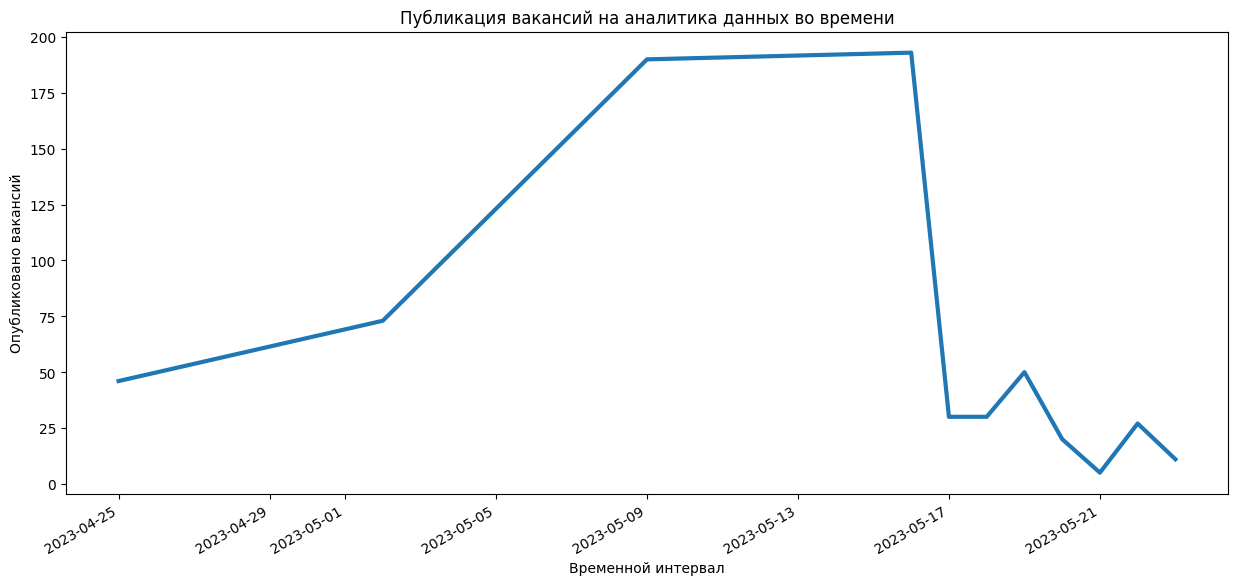

In [ ]:
#Строим график
fig = plt.subplots(figsize=(15, 6))
sns.lineplot(x="date_publс", y="counts_jobs", linewidth=3, data=date_jobs)
#plt.grid()
plt.title("Публикация вакансий на аналитика данных во времени");
plt.xlabel('Временной интервал')
plt.ylabel('Опубликовано вакансий')
#plt.xticks(dau_list);
plt.xticks(rotation=30, ha = 'right')
plt.show();

Вакансии, опубликованные 2-3 недели назад (с 09/05/23 по 17/05/23) имеют стабильно высокое число откликов, в последнюю же неделю показатели маленькие, так как 1. данные размазаны по дням, 2. вакансии увидели еще не все соискатели.  

### Количество кандидатов на вакансию

In [ ]:
'{:.1%}'.format(jobs.query('applicants=="unknown"')['applicants'].count() / jobs.shape[0])

'10.2%'

У чуть больше, чем 10 % процентов вакансий нет откликов, пожалуй это похоже на правду. Возможно, вакансии еще не успели набрать откликов или в принципе не интересны соискателям (из-за плохого описания, например).

Уберем повторяющийся текст, заменим неизвестное на 0.

In [ ]:
jobs['applicants'] = jobs['applicants'].apply(lambda x: x.replace('applicants','').strip())

jobs['applicants'] = jobs['applicants'].apply(lambda x: x.replace('unknown','0'))

In [ ]:
jobs['applicants'].value_counts()

Over 200    85
0           69
25          11
4           11
19          10
            ..
96           1
130          1
184          1
63           1
198          1
Name: applicants, Length: 167, dtype: int64

Наша задача привести этот столбец к числовому типу. Но сначала заменим значение Over 200 на рандомные числовые значения с 201 до 300. Так данные будут распределены равномерно и без искусственного пика.

In [ ]:
jobs['applicants'] = jobs['applicants'].apply(lambda x: x if x!="Over 200" else np.random.randint(201, 300))
jobs['applicants'] = jobs['applicants'].astype('int')

Проверим, как распределились данные на графике

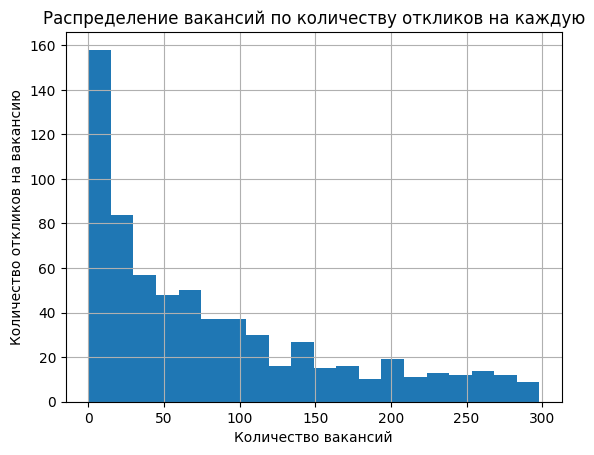

In [ ]:
jobs['applicants'].hist(bins = 20);
plt.ylabel('Количество откликов на вакансию')
plt.xlabel('Количество вакансий')
plt.title('Распределение вакансий по количеству откликов на каждую')
plt.show()


Очень много вакансий (=компаний), на которые откликается всего до 10 человек, график ведет себя ожидаемо и идет на спад, значит все сделали верно.

### Страна

Страну будем вытягивать из location, этот столбец хранит адрес целиком. Посмотрим, как он выглядит.

In [ ]:
jobs.location.value_counts()

Milan, Lombardy, Italy                 31
Paris, Île-de-France, France           20
Madrid, Community of Madrid, Spain     18
Warsaw, Mazowieckie, Poland            17
London, England, United Kingdom        12
                                       ..
Utrecht, Netherlands                    1
Gillingham, England, United Kingdom     1
Emmen, Drenthe, Netherlands             1
Guissona, Catalonia, Spain              1
Greater Munich Metropolitan Area        1
Name: location, Length: 360, dtype: int64

Во всех данных страна идет последней в списке, отщипнем ее от локации и поместим в соответствующее поле country. Для ситуации, когда в строке нет разделителя "," -  проставим unknown и более детально посмотрим такие значения.

In [ ]:
jobs['country'] = jobs['location'].apply(lambda x: x.split(',')[-1].strip() if ',' in x else 'unknown')

In [ ]:
jobs.country.value_counts(dropna=False, normalize=True)

Italy             0.164444
France            0.122963
Germany           0.120000
United Kingdom    0.100741
unknown           0.093333
Netherlands       0.069630
Spain             0.060741
Belgium           0.047407
Poland            0.045926
Sweden            0.023704
Ireland           0.020741
Portugal          0.020741
Greece            0.014815
Luxembourg        0.014815
Austria           0.010370
Hungary           0.010370
Czechia           0.010370
Bulgaria          0.007407
Switzerland       0.005926
Lithuania         0.005926
Malta             0.004444
Norway            0.004444
Denmark           0.004444
Romania           0.004444
Latvia            0.002963
Slovakia          0.002963
Estonia           0.001481
Finland           0.001481
Monaco            0.001481
Croatia           0.001481
Name: country, dtype: float64

9% значений не получилось обработать, из-за того, что в локации указана только страна или какой-то регион/город без страны. Напишем функцию, которая будет находить страну по городу ( в соответствии со словарем, который мы пропишем отдельно), или страну - если такая уже ранее встречалась в датасете.

In [ ]:
#Словарь замены городна на страну
town_country_dic = {
    'Netherlands':['Amsterdam','Eindhoven','Rotterdam'],
    'Germany':['Berlin','Cologne','Munich','Munster','Nuremberg','Stuttgart'],
    'Belgium':['Brussels'],
    'Slovakia':['Banska','Bystrica'],
    'Spain':['Barcelona','Palma de Mallorca','Pau'],
    'France':['Paris'],
    'Poland':['Krakow','Warsaw','Wroclaw'],
    'United Kingdom':['Manchester'],
    'Italy':['Milan'],
    'Czech':['Prague'],
    'Greece':['Athens']
  }

#список всех стран датасета
city_list = list(jobs['country'].unique())

In [ ]:
def find_country(df):
  if df['country']=='unknown':
    for c in city_list:
      if c in df['location']:
        return c
      else:
        for i in town_country_dic.keys():
          for k in town_country_dic[i]:
            if k in df['location']:
              return i
  else:
    return df['country']

In [ ]:
jobs['country'] = jobs.apply(find_country, axis = 1)

In [ ]:
jobs.country.value_counts(dropna=False)

Italy             118
Germany            92
France             88
United Kingdom     68
Netherlands        52
Spain              48
Poland             44
Belgium            35
Sweden             16
Portugal           16
Ireland            14
Greece             11
Luxembourg         10
Bulgaria            8
Hungary             8
Austria             7
Czechia             7
Lithuania           5
Denmark             4
Switzerland         4
Malta               3
Slovakia            3
Norway              3
Romania             3
Latvia              2
Finland             2
Estonia             1
Czech               1
Monaco              1
Croatia             1
Name: country, dtype: int64

Теперь мы нашли все страны, можем идти дальше.

### Хард - скилы

In [ ]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675 entries, 0 to 674
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   html              675 non-null    object        
 1   id_job            675 non-null    object        
 2   name              675 non-null    object        
 3   company_name      675 non-null    object        
 4   workplace_type    675 non-null    object        
 5   company_staff     675 non-null    object        
 6   company_scope     675 non-null    object        
 7   date_publication  675 non-null    object        
 8   applicants        675 non-null    int64         
 9   location          675 non-null    object        
 10  description       675 non-null    object        
 11  skills            675 non-null    object        
 12  date_publс        675 non-null    datetime64[ns]
 13  country           675 non-null    object        
dtypes: datetime64[ns](1), int6

Для начала определем объем вакансий с ненайденными скилами и решим, можем ли мы с этим что-то сделать.

In [ ]:
jobs.query('skills=="unknown"')['skills'].count() / jobs.shape[0]

0.07851851851851852

In [ ]:
jobs.query('skills==""')['skills'].count() / jobs.shape[0]

0.0

8% - это адекватный показатель. Мы выборочно посмотрели описание нескольких таких вакансий и там действительно не указаны хард скилы. Значит оставим эти данные как есть.

Чтобы подготовить данные к визуализации, сделаем так, чтобы 1 скилл = 1 строка. Воспользуемся функцией взрыва explode. Уникальность вакансии будем отслеживать по id_job, преобразуем это поле к числовому типу.

In [ ]:
jobs['id_job'] = jobs['id_job'].astype('int')

In [ ]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675 entries, 0 to 674
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   html              675 non-null    object        
 1   id_job            675 non-null    int64         
 2   name              675 non-null    object        
 3   company_name      675 non-null    object        
 4   workplace_type    675 non-null    object        
 5   company_staff     675 non-null    object        
 6   company_scope     675 non-null    object        
 7   date_publication  675 non-null    object        
 8   applicants        675 non-null    int64         
 9   location          675 non-null    object        
 10  description       675 non-null    object        
 11  skills            675 non-null    object        
 12  date_publс        675 non-null    datetime64[ns]
 13  country           675 non-null    object        
dtypes: datetime64[ns](1), int6

ТЕперь "взорвем" список скилов в отдельные строки.

In [ ]:
#превратим строку в список
jobs['skills'] = jobs['skills'].apply(lambda x: x.split(','))

In [ ]:
#взрываем список скилов
jobs = jobs.explode('skills').reset_index(drop= True )

In [ ]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2962 entries, 0 to 2961
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   html              2962 non-null   object        
 1   id_job            2962 non-null   int64         
 2   name              2962 non-null   object        
 3   company_name      2962 non-null   object        
 4   workplace_type    2962 non-null   object        
 5   company_staff     2962 non-null   object        
 6   company_scope     2962 non-null   object        
 7   date_publication  2962 non-null   object        
 8   applicants        2962 non-null   int64         
 9   location          2962 non-null   object        
 10  description       2962 non-null   object        
 11  skills            2962 non-null   object        
 12  date_publс        2962 non-null   datetime64[ns]
 13  country           2962 non-null   object        
dtypes: datetime64[ns](1), in

Посмотрим, что получилось.

In [ ]:
jobs.skills.value_counts().head(50)

sql                      262
python                   203
excel                    201
power bi                 187
ai                       135
r                        132
tableau                  130
agile                     87
statistics                83
powerbi                   62
dashboard                 55
power point               55
unknown                   53
powerpoint                50
azure                     41
etl                       38
google analytics          38
sas                       36
sap                       36
looker                    33
data warehouse            33
big query                 32
qlik                      31
ms office                 31
aws                       29
data engineering          28
data mining               27
informatica               24
salesforce                23
qlik sense                22
jira                      22
vba                       21
data studio               21
hadoop                    20
bigquery      

Теперь унифицируем одинаковые названия, избавимся от неявных дубликатов

In [ ]:
#словарь замен скилов
rep_dic = {'power point':'powerpoint',
           'powerbi':'power bi',
           'ab testing':'a/b testing',
           'bigquery': 'big query',
           'github':'git',
           'oracle data integrator':'oracle',
           'sap business objects':'sap'}

In [ ]:
jobs['skills'] = jobs['skills'].replace(to_replace=rep_dic)

In [ ]:
jobs.skills.value_counts().head(50)

sql                      262
power bi                 249
python                   203
excel                    201
ai                       135
r                        132
tableau                  130
powerpoint               105
agile                     87
statistics                83
dashboard                 55
unknown                   53
big query                 52
azure                     41
sap                       39
etl                       38
google analytics          38
sas                       36
looker                    33
data warehouse            33
ms office                 31
qlik                      31
aws                       29
data engineering          28
data mining               27
informatica               24
salesforce                23
qlik sense                22
jira                      22
data studio               21
vba                       21
hadoop                    20
a/b testing               20
oracle                    20
google cloud p

### Удаление лишних столбцов

In [ ]:
jobs.head()

,html,id_job,name,company_name,workplace_type,company_staff,company_scope,date_publication,applicants,location,description,skills,date_publс,country
0,"\n <div>\n <div class=""\n jobs-deta...",3609065367,Data Analyst,PharmiWeb.Jobs: Global Life Science Jobs,on-site,11-50 employees,Human Resources,1 week ago,47,"Basel, Basel, Switzerland",\n\n About the job\n \n\n \n ...,data mining,2023-05-16,Switzerland
1,"\n <div>\n <div class=""\n jobs-deta...",3609065367,Data Analyst,PharmiWeb.Jobs: Global Life Science Jobs,on-site,11-50 employees,Human Resources,1 week ago,47,"Basel, Basel, Switzerland",\n\n About the job\n \n\n \n ...,excel,2023-05-16,Switzerland
2,"\n <div>\n <div class=""\n jobs-deta...",3609065367,Data Analyst,PharmiWeb.Jobs: Global Life Science Jobs,on-site,11-50 employees,Human Resources,1 week ago,47,"Basel, Basel, Switzerland",\n\n About the job\n \n\n \n ...,sap,2023-05-16,Switzerland
3,"\n <div>\n <div class=""\n jobs-deta...",3609065367,Data Analyst,PharmiWeb.Jobs: Global Life Science Jobs,on-site,11-50 employees,Human Resources,1 week ago,47,"Basel, Basel, Switzerland",\n\n About the job\n \n\n \n ...,sas,2023-05-16,Switzerland
4,"\n <div>\n <div class=""\n jobs-deta...",3609065367,Data Analyst,PharmiWeb.Jobs: Global Life Science Jobs,on-site,11-50 employees,Human Resources,1 week ago,47,"Basel, Basel, Switzerland",\n\n About the job\n \n\n \n ...,spss,2023-05-16,Switzerland


In [ ]:
dash_jobs = jobs.drop(columns=['html', 'location','description','date_publication']).copy()
dash_jobs = dash_jobs.rename(columns = {'name':'job_name'})

In [ ]:
dash_jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2962 entries, 0 to 2961
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id_job          2962 non-null   int64         
 1   job_name        2962 non-null   object        
 2   company_name    2962 non-null   object        
 3   workplace_type  2962 non-null   object        
 4   company_staff   2962 non-null   object        
 5   company_scope   2962 non-null   object        
 6   applicants      2962 non-null   int64         
 7   skills          2962 non-null   object        
 8   date_publс      2962 non-null   datetime64[ns]
 9   country         2962 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 231.5+ KB


In [ ]:
print('Итого, в нашем датасете содержится: ')
print(jobs.id_job.nunique(),'вакансий')
print(jobs.company_name.nunique(),'компаний')
print(jobs.country.nunique(),'стран')
print(jobs.skills.nunique(),'разных скилов')

Итого, в нашем датасете содержится: 
675 вакансий
503 компаний
30 стран
159 разных скилов


Этого будет достаточно для хорошей визуализации данных. Выгрузим наши данные в csv.

In [ ]:
#выгрузка в csv
dash_jobs.to_csv('dash_jobs.csv', index=False)
#!cp dash_jobs.csv "drive/My Drive/"

Все предварительные работы для визуализации выполнены.

## Визуализация данных

ссылка на дашборд: https://datalens.yandex/ui538detirbck?state=707e557a407
<br> В качестве среды для визуализации данных был выбран сервис Datalens Yandex.

 На дашборде отображены следующие срезы:

*   индикатор вакансий
*   вакансии по странам
*   hurd skills
*   топ 10 сфер деятельности нанимающих компаний
*   размерность нанимающих компаний
*   список компаний, где требуются аналитики
*   статистика формата работы в вакансиях
+ фильтры по стране и формату работы

